# Examples for lecture Clustering and Association Rules

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import pandas as pd
from ipywidgets import interact

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

%matplotlib inline

# k-Means Clustering

## k-Means from Scratch

### Generate Data

In [25]:
X, _ = make_blobs(n_samples=20, centers=3, n_features=2, random_state=0)

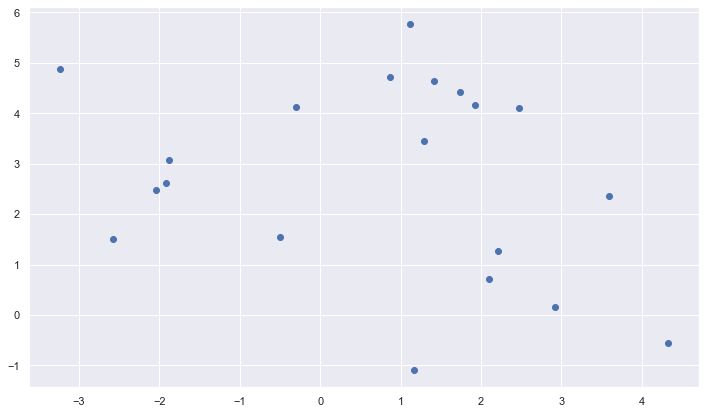

In [26]:
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(X[:, 0], X[:, 1])

### Randomly choose k cluster centers

In [27]:
def initialize_centroids(X, k):
    centroids = X.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

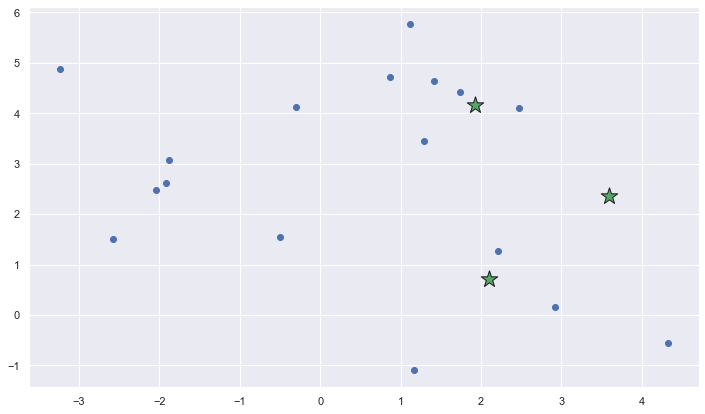

In [28]:
centroids = initialize_centroids(X, k=3)

fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(X[:, 0], X[:, 1])
ax.scatter(centroids[:, 0], centroids[:, 1], s=300, marker="*", c="g", edgecolor="k")

### Assign each data point to its nearest cluster center

In [29]:
def closest_centroid(X, centroids):
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

In [30]:
closest = closest_centroid(X, centroids)
closest

array([2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 0, 2],
      dtype=int64)

Text(0.5, 1.0, 'Initial')

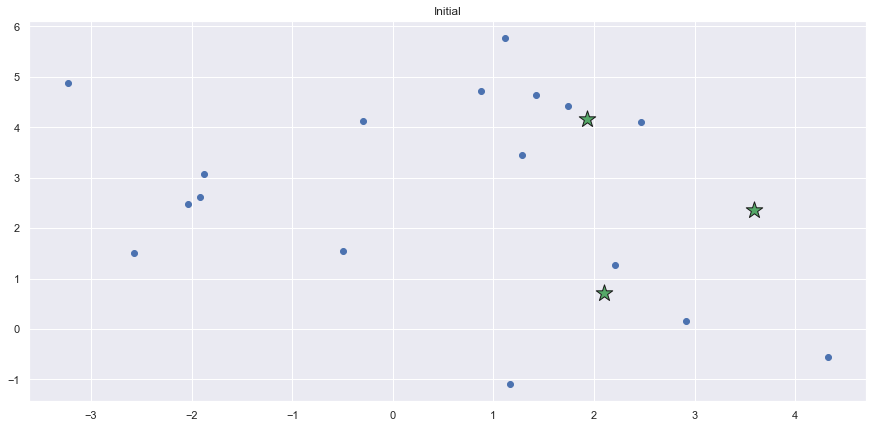

In [31]:
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(X[:, 0], X[:, 1])
ax.scatter(centroids[:, 0], centroids[:, 1], s=300, marker="*", c="g", edgecolor="k")
ax.set_title("Initial")

#### Update each cluster center to the mean of all assigned data points

In [32]:
def move_centroids(X, closest, centroids):
    return np.array([X[closest==k].mean(axis=0) for k in range(centroids.shape[0])])

In [33]:
move_centroids(X, closest, centroids)

array([[1.37860991, 0.50730234],
       [3.58804674, 2.36702243],
       [0.12345506, 4.03288833]])

In [34]:
num_iterations = 10
centroids_hist = [centroids]
centroids_moved = centroids

for i in range(num_iterations):
    closest = closest_centroid(X, centroids_moved)
    centroids_moved = move_centroids(X, closest, centroids_moved)
    centroids_hist.append(centroids_moved)

@interact(iteration=(0, len(centroids_hist)))
def k_means_centroids(iteration=0):
    fig, ax = plt.subplots(figsize=(15,7))
    centroids = centroids_hist[iteration]
    ax.scatter(X[:, 0], X[:, 1])
    ax.scatter(centroids[:, 0], centroids[:, 1], s=300, marker="*", c="g", edgecolor="k")
    ax.set_title("Iteration {}".format(iteration))
    plt.show()

interactive(children=(IntSlider(value=0, description='iteration', max=11), Output()), _dom_classes=('widget-in…

### Implement the algorithm

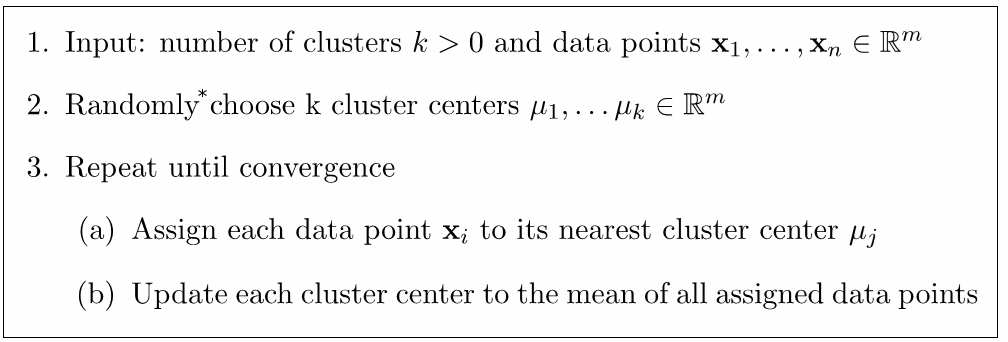

In [35]:
def fit(X, k):
    centroids = initialize_centroids(X, k)
    closest_before = closest_centroid(X, centroids)

    while True:
        closest = closest_centroid(X, centroids)
        centroids = move_centroids(X, closest, centroids)
        
        if np.all(closest == closest_before):
            break
        closest_before = closest
    return closest, centroids 

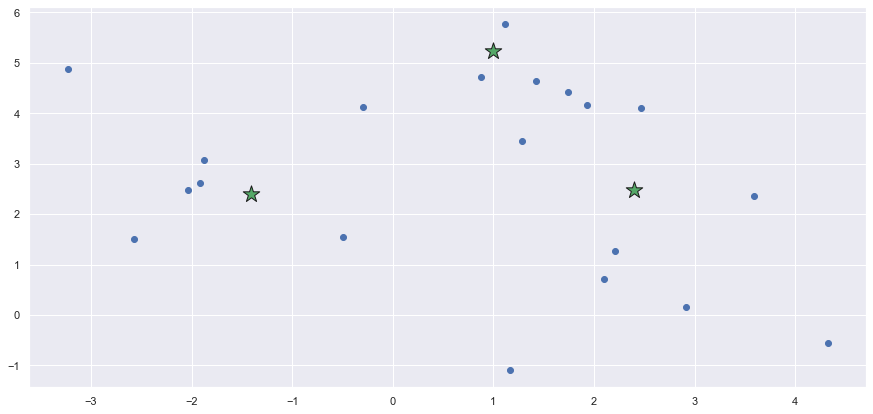

In [36]:
closest, centroids = fit(X, k=3)

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(X[:, 0], X[:, 1])
ax.scatter(centroids[:, 0], centroids[:, 1], s=300, marker="*", c="g", edgecolor="k")

## Scikit-Learn

In [38]:
model = KMeans(n_clusters=3, random_state=0).fit(X)

In [39]:
model.labels_

array([2, 0, 2, 1, 1, 0, 0, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 0, 1, 2])

In [ ]:
centroids = model.cluster_centers_

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(X[:, 0], X[:, 1])
ax.scatter(centroids[:, 0], centroids[:, 1], s=300, marker="*", c="g", edgecolor="k")

### Distortion

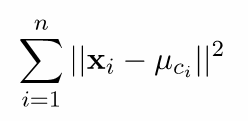

In [40]:
model.inertia_

33.944715137557345

### Average Distortion

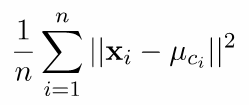

In [41]:
model.inertia_ / len(X)

1.6972357568778673

## Convergence

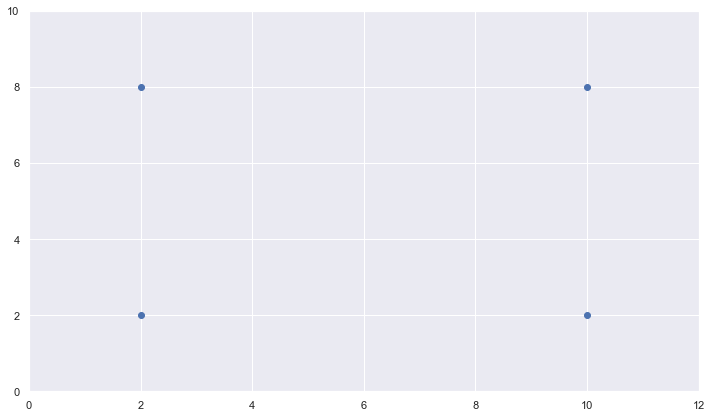

In [15]:
X = np.array([
    [2, 2],
    [2, 8],
    [10, 8],
    [10, 2]
])

fig, ax = plt.subplots(figsize=(12,7))
ax.set_xlim(0, 12)
ax.set_ylim(0, 10)
ax.scatter(X[:, 0], X[:, 1])

### Our implementation

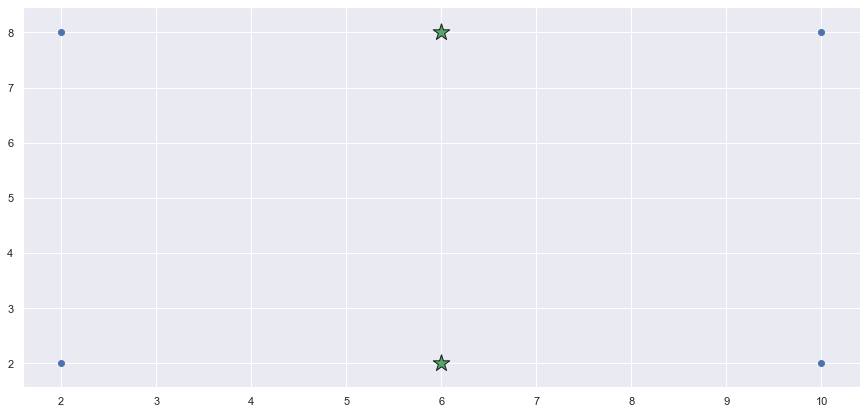

In [18]:
closest, centroids = fit(X, k=2)

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(X[:, 0], X[:, 1])
ax.scatter(centroids[:, 0], centroids[:, 1], s=300, marker="*", c="g", edgecolor="k")

### Scikit-Learn

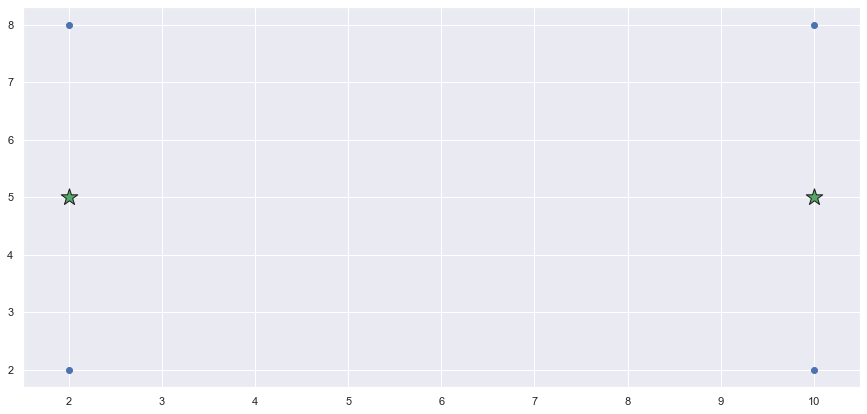

In [19]:
model = KMeans(n_clusters=2, random_state=0, n_init=10, init="k-means++").fit(X)
centroids = model.cluster_centers_

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(X[:, 0], X[:, 1])
ax.scatter(centroids[:, 0], centroids[:, 1], s=300, marker="*", c="g", edgecolor="k")

## Number of Clusters

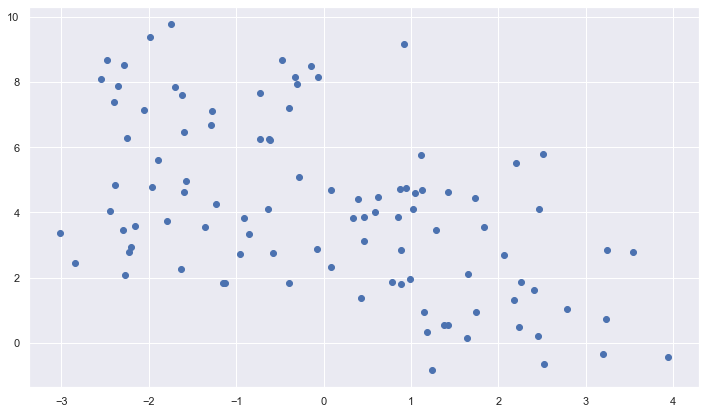

In [42]:
X, _ = make_blobs(n_samples=100, centers=4, n_features=2, random_state=0)
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(X[:, 0], X[:, 1])

#### Elbow Plot

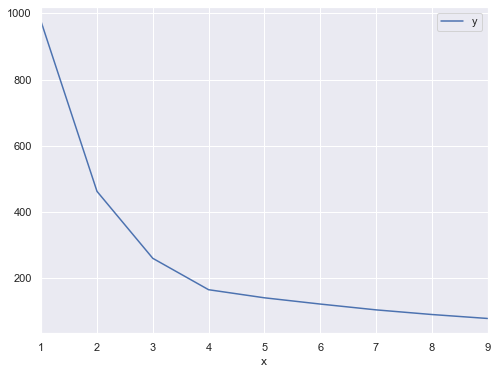

In [43]:
distortions = []
k_values = range(1,10)
for k in tqdm(k_values):
    model = KMeans(n_clusters=k, random_state=0).fit(X)
    distortions.append(model.inertia_)
    
pd.DataFrame(dict(x=k_values, y=distortions)).plot(x="x", y="y", xticks=k_values, grid=True, figsize=(8,6))

# Association Rules

In [47]:
transactions = [
    ["burger", "salad", "coke", "ice cream"],
    ["burger", "salad", "coke", "ice cream"],
    ["burger", "fries", "coke", "pie"],
    ["burger", "salad", "coke", "choc bar"],
    ["burger", "salad", "coke", "muffin"],
    ["sandwich", "fries", "fanta", "pie"],
    ["sandwich", "fries", "coke", "pie"],
    ["sandwich", "onion rings", "water", "muffin"]
]

 
transactions = pd.DataFrame(data={"Items":transactions}, index=range(1,9))
transactions.index.name = 'Id'

with pd.option_context('display.max_colwidth', 80):
    print(transactions)

                                     Items
Id                                        
1         [burger, salad, coke, ice cream]
2         [burger, salad, coke, ice cream]
3               [burger, fries, coke, pie]
4          [burger, salad, coke, choc bar]
5            [burger, salad, coke, muffin]
6            [sandwich, fries, fanta, pie]
7             [sandwich, fries, coke, pie]
8   [sandwich, onion rings, water, muffin]


## Apriori Algorithm

### 1. Encode ransactions

In [48]:
te = TransactionEncoder()
te_ary = te.fit_transform(transactions.Items.values.tolist())
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,burger,choc bar,coke,fanta,fries,ice cream,muffin,onion rings,pie,salad,sandwich,water
0,True,False,True,False,False,True,False,False,False,True,False,False
1,True,False,True,False,False,True,False,False,False,True,False,False
2,True,False,True,False,True,False,False,False,True,False,False,False
3,True,True,True,False,False,False,False,False,False,True,False,False
4,True,False,True,False,False,False,True,False,False,True,False,False
5,False,False,False,True,True,False,False,False,True,False,True,False
6,False,False,True,False,True,False,False,False,True,False,True,False
7,False,False,False,False,False,False,True,True,False,False,True,True


### 2. Extract frequent item sets

In [49]:
freq_itemsets = apriori(df, use_colnames=True, min_support=0.5)
freq_itemsets

,support,itemsets
0,0.625,(burger)
1,0.750,(coke)
2,0.500,(salad)
3,0.625,"(coke, burger)"
4,0.500,"(salad, burger)"
5,0.500,"(salad, coke)"
6,0.500,"(salad, coke, burger)"


### 3. Generate rules

In [50]:
# Execute the following code to show the solution
association_rules(freq_itemsets, metric='confidence', min_threshold=0.75)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(coke),(burger),0.750,0.625,0.625,0.833333,1.333333,0.15625,2.25
1,(burger),(coke),0.625,0.750,0.625,1.000000,1.333333,0.15625,inf
2,(salad),(burger),0.500,0.625,0.500,1.000000,1.600000,0.18750,inf
3,(burger),(salad),0.625,0.500,0.500,0.800000,1.600000,0.18750,2.50
4,(salad),(coke),0.500,0.750,0.500,1.000000,1.333333,0.12500,inf
5,"(salad, coke)",(burger),0.500,0.625,0.500,1.000000,1.600000,0.18750,inf
6,"(salad, burger)",(coke),0.500,0.750,0.500,1.000000,1.333333,0.12500,inf
7,"(coke, burger)",(salad),0.625,0.500,0.500,0.800000,1.600000,0.18750,2.50
8,(salad),"(coke, burger)",0.500,0.625,0.500,1.000000,1.600000,0.18750,inf
9,(burger),"(salad, coke)",0.625,0.500,0.500,0.800000,1.600000,0.18750,2.50
